In [49]:
# Setup 기본 설정
import numpy as np
import matplotlib.pyplot as plt

# Setup FIR 필터링을 위한 scipy.signal 임포트
from scipy.signal import lfilter, freqz
from scipy.signal import firwin   # firwin 사용
from scipy.signal import remez    # remez 사용
from scipy.signal import firls    # firls 사용

#
# Jupyter에서 그래프 크게 보기
#
plt.rcParams["figure.figsize"] = (8, 3)

In [50]:
# RF Mixer - 곱셈(Multiplication)으로 주파수/위상 차이 생성

fs = 2000_000        # Sampling Frequency 2000 kHz 
T  = 0.000125        # 0.125 ms   Y축 
t  = np.linspace(0, T, int(fs*T), endpoint=False)

f_lo = 100_000      # LO = 100 kHz
f_rf = 120_000      # RF = 120 kHz

phase_lo = 0.0
phase_rf = np.deg2rad(30)  # RF 위상 30도

lo = np.cos(2*np.pi*f_lo*t + phase_lo)
rf = np.cos(2*np.pi*f_rf*t + phase_rf)

# RF Mixer: 곱셈
y_rf = lo * rf      # x_out = x1 * x2

# Δf Frequency Difference and Sum
f_dif_1 = abs(f_rf - f_lo)  # 20 kHz
f_sum_1 = abs(f_rf + f_lo)  # 220 kHz

# Δφ Phase Difference and Sum
phase_dif = phase_rf - phase_lo   
phase_sum = phase_rf + phase_lo
phi_diff_deg = np.rad2deg(phase_dif) # 도(degree)로 보기 좋게
phi_pi = phase_dif / np.pi  # π 기준 환산

# Expected Comparison Signals (믹서 곱셈의 결과가 0.5 배이므로)
ideal_020k = 0.5 * np.cos(2*np.pi*f_dif_1*t + phase_dif)
ideal_220k = 0.5 * np.cos(2*np.pi*f_sum_1*t + phase_sum)



### **1. Digital FIR Filter**   

* [Digtal Filters](https://en.wikipedia.org/wiki/Filter_design#Digital_filters)     
    * [FIR(finite impulse response)](https://en.wikipedia.org/wiki/Finite_impulse_response)        


<br/>

* [FIR Filter Design](https://en.wikipedia.org/wiki/Finite_impulse_response#Filter_design)      
       

| 분류 | 개념 요약 | 장점 | 단점 |
|------|----------|------|------|
| **Window Design Method** | Ideal filter(sinc) → 윈도우로 자름 | 단순, 계산 가벼움 | 스펙(리플/Transition) 제어 약함 |
| **Frequency Sampling Method** | 원하는 주파수 응답을 샘플링 후 IFFT | 임의 주파수 응답 구현 자유도 ↑ | Stopband 획득 어려움, 안정성 ↓ |
| **Conventional Linear Programming** (Least-square 포함) | L2/L∞ Error 최소화 → 선형 제약조건 해석적 해결 | 특정 응답 근사 정확 | 구현 난이도 있음 |
| **Iterative Linear Programming** (예: Parks-McClellan) | Chebyshev 기반 오차 동등화(Equiripple) → 반복 최적화 | 산업 표준급 성능 | 연산복잡도 ↑, 구현 어려움 |

![](./imgs/fir_00.png)

In [51]:
# ================================
#  1. FIR Filter 
#    A.LPF
#    B.HPF 
# ===============================

num_taps = 101        # FIR 필터 탭 수 (데모용으로 101, 원하면 더 늘려도 됨)
#
#  FIR 필터 group delay 만큼 버림
#
delay = (num_taps - 1) // 2  # group delay = 50 samples



In [52]:
lpf_cutoff = 60_000   # 60 kHz 까지 통과 (20 kHz는 확실히 통과, 220 kHz는 최대한 억제)
hpf_cutoff = 100_000  # 100 kHz 이상만 통과 → 220 kHz 성분 통과, 20 kHz는 억제

### **1.1 FIR Window design method**   

* [FIR Filter Design](https://en.wikipedia.org/wiki/Finite_impulse_response#Filter_design)
    * **Window design method**    
    * Frequency Sampling method   
    * Conventional linear programming   
    * Iterative linear programming  

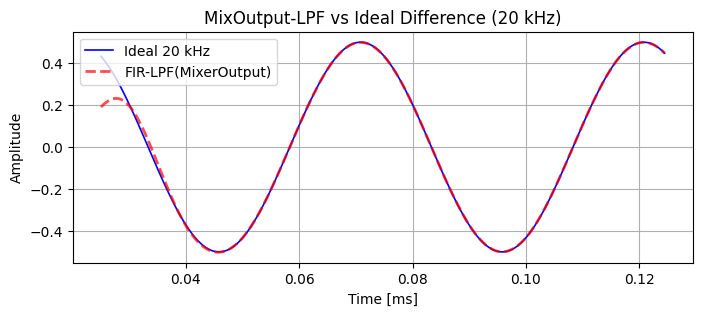

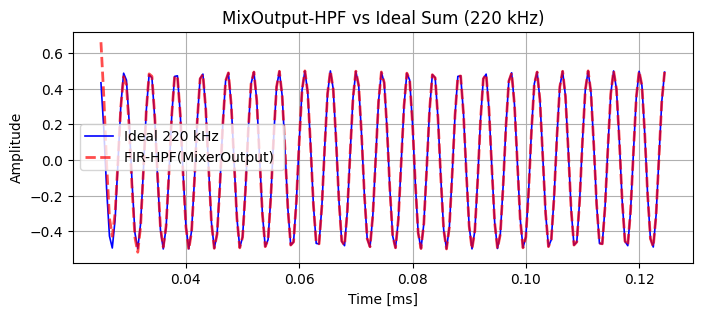

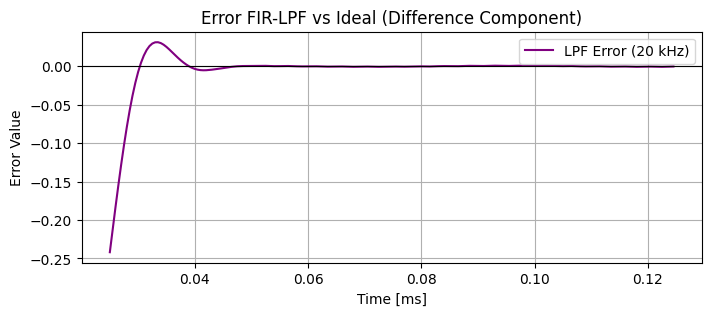

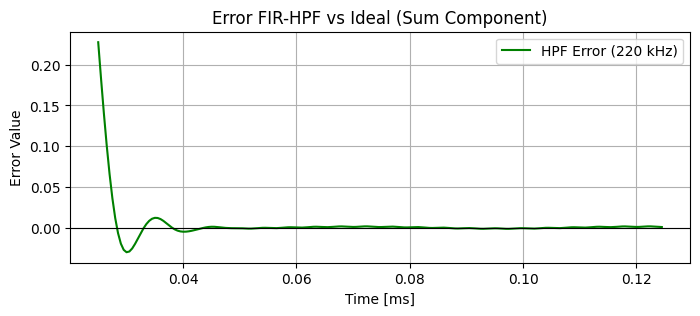

In [53]:

# 1.1 FIR Filter Design: Window design method 
# Window Hamming (default)
lpf = firwin(num_taps, cutoff=lpf_cutoff, fs=fs)  # 저역 통과 FIR
hpf = firwin(num_taps, cutoff=hpf_cutoff, fs=fs, pass_zero=False)     # 고역 통과 FIR

# ================================
# 2. Mixer 출력에 필터 적용
# ================================
y_lpf = lfilter(lpf, 1.0, y_rf)   # 저역통과 결과 (20 kHz 근처)
y_hpf = lfilter(hpf, 1.0, y_rf)   # 고역통과 결과 (220 kHz 근처)

#
# 유효 구간만 추출 (필터 지연 고려)
t_valid = t[delay:]
y_lpf_valid = y_lpf[delay:]
y_hpf_valid = y_hpf[delay:]

# Ideal 과 동일한 Sample 수로 맞춤 (필터 지연 고려하지 않고 단순 자름)
ideal_20k_valid =  ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]



# figure 3-2. LPF 결과와 이론적인 Δf(20 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid  , label="Ideal 20 kHz"          , color="blue"  , linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid      , label="FIR-LPF(MixerOutput)"  , color="red"   , linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# figure 3-3. HPF 결과와 이론적인 합 주파수(220 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid , label="Ideal 220 kHz"         , color="blue"  ,linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid      , label="FIR-HPF(MixerOutput) " , color="red"   ,linewidth=2.0, linestyle="--" , alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()


# Real vs Ideal 비교를 위한 오차 계산
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)", color="purple")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)", color="green")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()


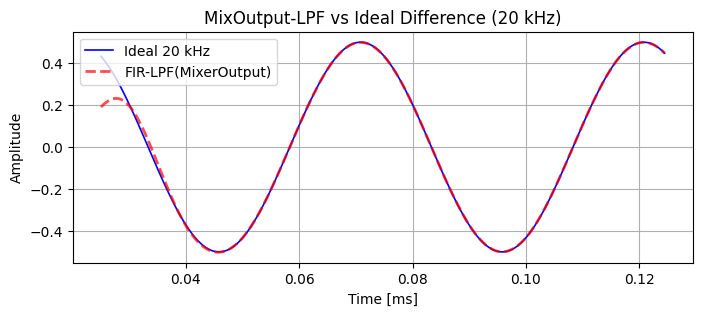

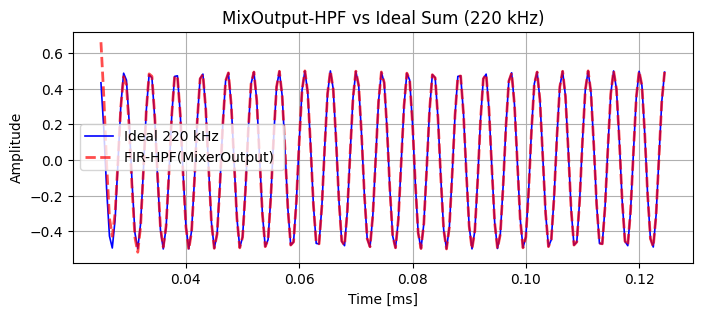

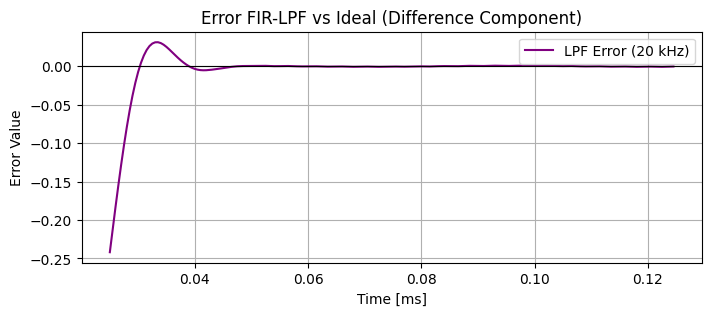

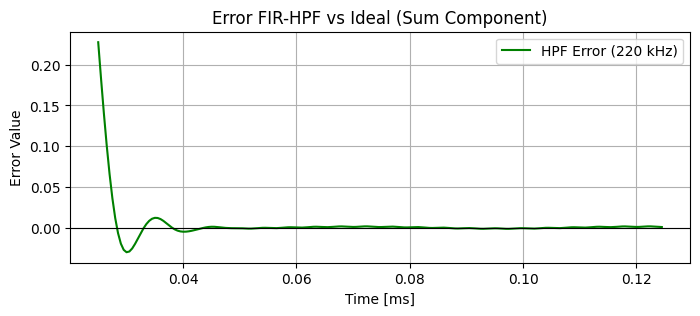

In [54]:

# 1.1 FIR Filter Design: Window design method 
# Window Hamming (default)
lpf = firwin(num_taps, cutoff=lpf_cutoff, fs=fs)  # 저역 통과 FIR
hpf = firwin(num_taps, cutoff=hpf_cutoff, fs=fs, pass_zero=False)     # 고역 통과 FIR

# ================================
# 2. Mixer 출력에 필터 적용
# ================================
y_lpf = lfilter(lpf, 1.0, y_rf)   # 저역통과 결과 (20 kHz 근처)
y_hpf = lfilter(hpf, 1.0, y_rf)   # 고역통과 결과 (220 kHz 근처)

#
# 유효한 구간만 추출 (필터 지연 고려)
#
t_valid = t[delay:]
y_lpf_valid = y_lpf[delay:]
y_hpf_valid = y_hpf[delay:]

# Ideal 과 동일한 Sample 수로 맞춤 (필터 지연 고려하지 않고 단순 자름)
ideal_20k_valid =  ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]



# figure 3-2. LPF 결과와 이론적인 Δf(20 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid  , label="Ideal 20 kHz"          , color="blue"  , linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid      , label="FIR-LPF(MixerOutput)"  , color="red"   , linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# figure 3-3. HPF 결과와 이론적인 합 주파수(220 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid , label="Ideal 220 kHz"         , color="blue"  ,linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid      , label="FIR-HPF(MixerOutput) " , color="red"   ,linewidth=2.0, linestyle="--" , alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()


# Real vs Ideal 비교를 위한 오차 계산
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)", color="purple")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)", color="green")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()


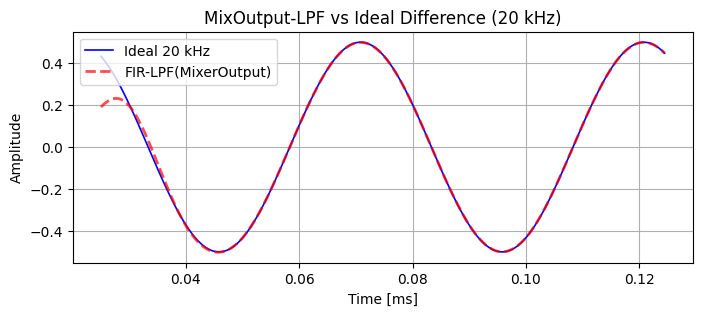

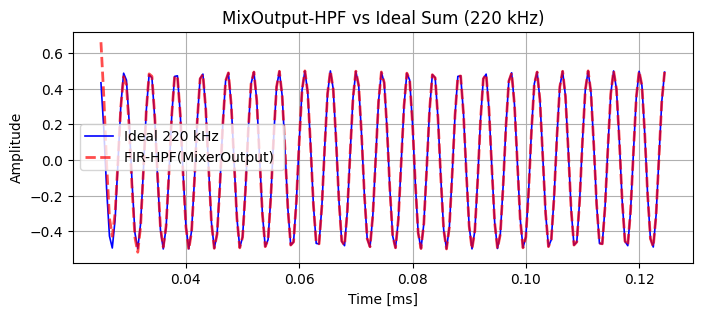

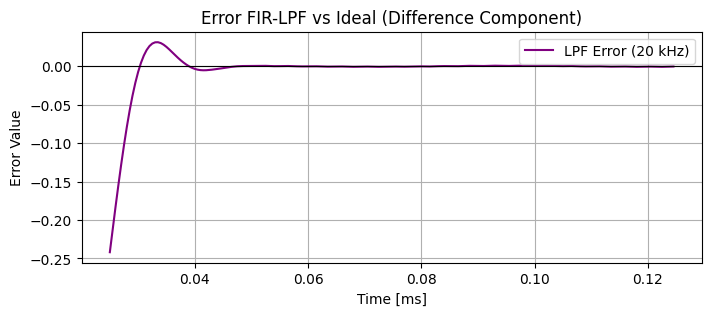

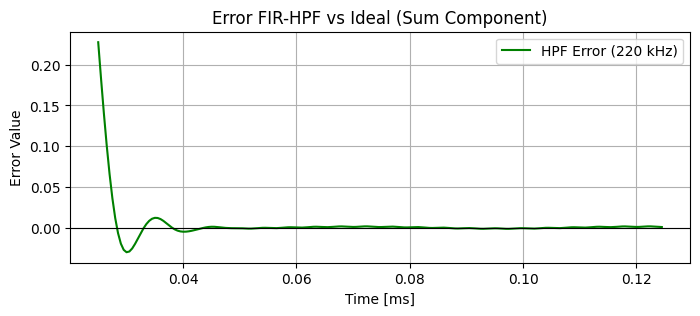

In [55]:

# 1.1 FIR Filter Design: Window design method 
# Window Hamming (default)
lpf = firwin(num_taps, cutoff=lpf_cutoff, fs=fs)  # 저역 통과 FIR
hpf = firwin(num_taps, cutoff=hpf_cutoff, fs=fs, pass_zero=False)     # 고역 통과 FIR

# ================================
# 2. Mixer 출력에 필터 적용
# ================================
y_lpf = lfilter(lpf, 1.0, y_rf)   # 저역통과 결과 (20 kHz 근처)
y_hpf = lfilter(hpf, 1.0, y_rf)   # 고역통과 결과 (220 kHz 근처)

#
# 유효한 구간만 추출 (필터 지연 고려)
#
t_valid = t[delay:]
y_lpf_valid = y_lpf[delay:]
y_hpf_valid = y_hpf[delay:]

# Ideal 과 동일한 Sample 수로 맞춤 (필터 지연 고려하지 않고 단순 자름)
ideal_20k_valid =  ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]



# figure 3-2. LPF 결과와 이론적인 Δf(20 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid  , label="Ideal 20 kHz"          , color="blue"  , linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid      , label="FIR-LPF(MixerOutput)"  , color="red"   , linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# figure 3-3. HPF 결과와 이론적인 합 주파수(220 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid , label="Ideal 220 kHz"         , color="blue"  ,linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid      , label="FIR-HPF(MixerOutput) " , color="red"   ,linewidth=2.0, linestyle="--" , alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()


# Real vs Ideal 비교를 위한 오차 계산
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)", color="purple")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)", color="green")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()


### **1.2 FIR Iterative linear programming**   

* [FIR Filter Design](https://en.wikipedia.org/wiki/Finite_impulse_response#Filter_design)
    * Window design method   
    * Frequency Sampling method   
    * Conventional linear programming   
    * **Iterative linear programming** 

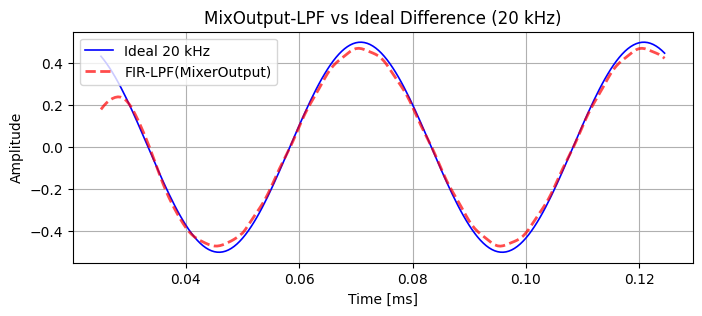

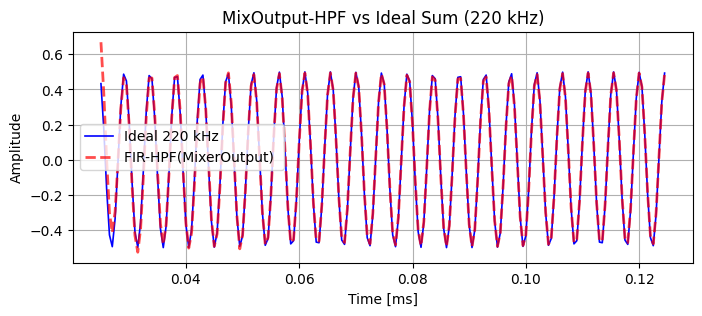

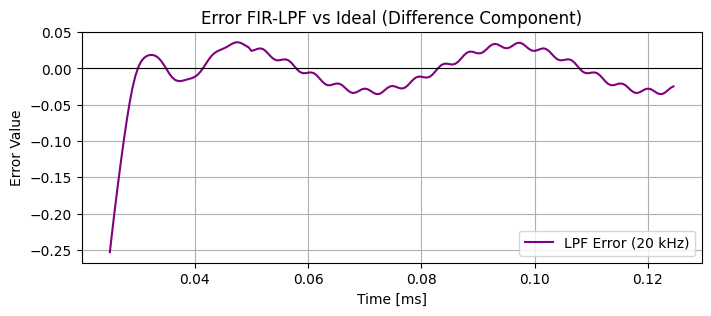

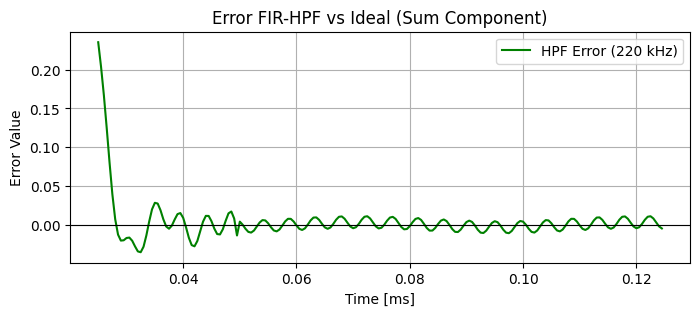

In [56]:

# Transition band 설정 (임의 예: 10~ 30 kHz 정도 )
transition_lpf = 30_000   # 설정에 따라 성능변경 가능
transition_hpf = 30_000   # 설정에 따라 성능변경 가능

# LPF: 0 ~ 60 kHz pass, 70 kHz ~ fs/2 stop
# bands: [0, fp, fs, fs/2]
lpf = remez(
    num_taps,
    bands=[0, lpf_cutoff, lpf_cutoff + transition_lpf, fs/2],
    desired=[1, 0],           # [passband gain, stopband gain]
    weight=[1, 10],           # stopband를 더 세게 억제하고 싶으면 뒤에 weight 크게
    fs=fs
)

# HPF: 0 ~ 90 kHz stop, 100 kHz ~ fs/2 pass
hpf = remez(
    num_taps,
    bands=[0, hpf_cutoff - transition_hpf, hpf_cutoff, fs/2],
    desired=[0, 1],           # [stopband gain, passband gain]
    weight=[10, 1],           # low freq 억제에 weight↑
    fs=fs
)

# ================================
# 2. Mixer 출력에 필터 적용 (이 아래는 그대로)
# ================================
y_lpf = lfilter(lpf, 1.0, y_rf)
y_hpf = lfilter(hpf, 1.0, y_rf)

delay = (num_taps - 1) // 2
t_valid       = t[delay:]
y_lpf_valid   = y_lpf[delay:]
y_hpf_valid   = y_hpf[delay:]

ideal_20k_valid  = ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]


# figure 3-2. LPF 결과와 이론적인 Δf(20 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid  , label="Ideal 20 kHz"          , color="blue"  , linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid      , label="FIR-LPF(MixerOutput)"  , color="red"   , linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# figure 3-3. HPF 결과와 이론적인 합 주파수(220 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid , label="Ideal 220 kHz"         , color="blue"  ,linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid      , label="FIR-HPF(MixerOutput) " , color="red"   ,linewidth=2.0, linestyle="--" , alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()


# Real vs Ideal 비교를 위한 오차 계산
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)", color="purple")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)", color="green")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()



### **1.3 FIR Conventional linear programming**   

* [FIR Filter Design](https://en.wikipedia.org/wiki/Finite_impulse_response#Filter_design)
    * Window design method   
    * Frequency Sampling method   
    * **Conventional linear programming**   
    * Iterative linear programming

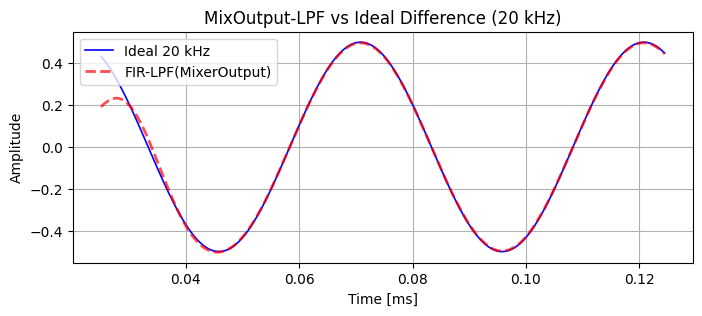

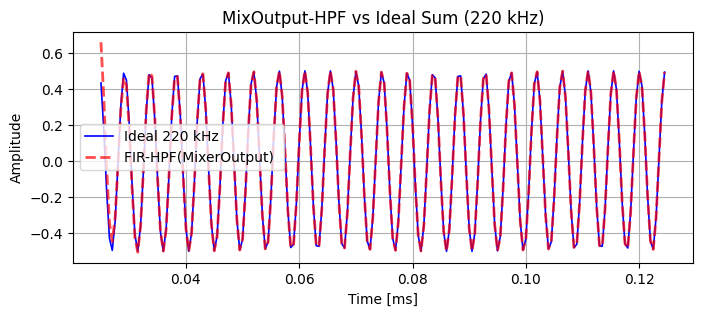

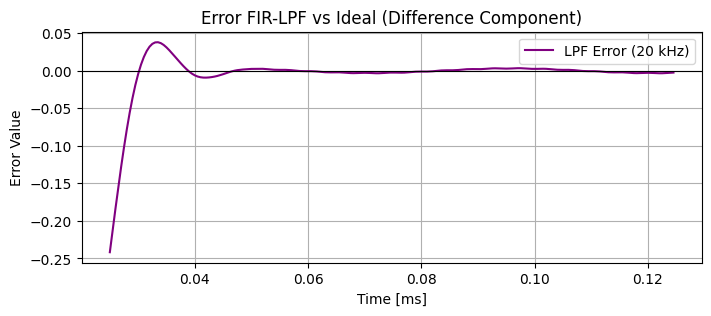

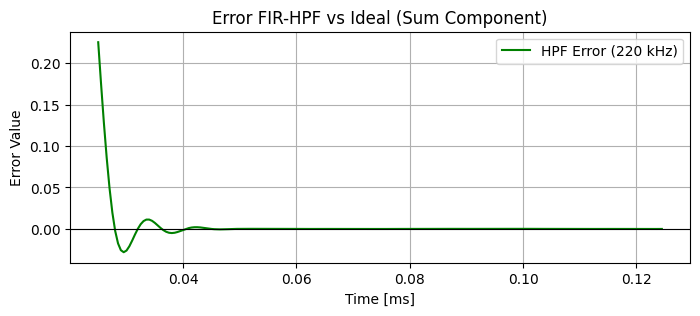

In [57]:
# 여기서 핵심은:
#  - LPF: 0 ~ 40 kHz pass, 80 kHz 이상 stop
#  - HPF: 0 ~ 80 kHz stop, 160 kHz 이상 pass
#  → 20 kHz / 220 kHz가 각 필터 passband의 '중간'에 오도록 여유 있게 설계
#    (너무 빡빡하게 안 잡는 게 101탭에서는 더 안정적)

# LPF 설계: bands = [0, fp, fsb, fs/2]
lpf_bands   = [0, 40_000, 80_000, fs/2]
lpf_desired = [1, 1, 0, 0]   # 0~40k: gain 1, 80k~Nyq: gain 0

lpf = firls(
    numtaps=num_taps,
    bands=lpf_bands,
    desired=lpf_desired,
    fs=fs
)

# HPF 설계: 0 ~ 80 kHz stop, 160 kHz 이상 pass
hpf_bands   = [0, 80_000, 160_000, fs/2]
hpf_desired = [0, 0, 1, 1]   # 0~80k: 0, 160k~Nyq: 1

hpf = firls(
    numtaps=num_taps,
    bands=hpf_bands,
    desired=hpf_desired,
    fs=fs
)

# ================================
# 2. Mixer 출력에 필터 적용 (이 밑은 네 코드 그대로)
# ================================
y_lpf = lfilter(lpf, 1.0, y_rf)   # 저역통과 결과 (20 kHz 근처)
y_hpf = lfilter(hpf, 1.0, y_rf)   # 고역통과 결과 (220 kHz 근처)

# FIR 필터 group delay 만큼 버림
delay = (num_taps - 1) // 2  # group delay = 50 samples

t_valid       = t[delay:]
y_lpf_valid   = y_lpf[delay:]
y_hpf_valid   = y_hpf[delay:]

# Ideal과 길이 맞추기
ideal_20k_valid  = ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]



# figure 3-2. LPF 결과와 이론적인 Δf(20 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid  , label="Ideal 20 kHz"          , color="blue"  , linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid      , label="FIR-LPF(MixerOutput)"  , color="red"   , linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# figure 3-3. HPF 결과와 이론적인 합 주파수(220 kHz) 비교
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid , label="Ideal 220 kHz"         , color="blue"  ,linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid      , label="FIR-HPF(MixerOutput) " , color="red"   ,linewidth=2.0, linestyle="--" , alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()


# Real vs Ideal 비교를 위한 오차 계산
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)", color="purple")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)", color="green")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Error FIR-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

